In [40]:
import numpy as np
import iris
from scipy.stats import expon, kstest
import matplotlib.pyplot as plt
import glob
import iris.plot as iplt

In [205]:
def estimate_tb0(rainfall_data, threshold, max_tb0_iterations=100, tolerance=0.01):
    # Identify rainy and dry periods
    rainy_periods = identify_rainy_periods(rainfall_data, threshold)
    
    # Initialize parameters
    tb0 = None
    iteration = 0
    
    # Iterate to estimate tb0
    while iteration < max_tb0_iterations:
        # Calculate inter-event times assuming tb0
        inter_event_times = calculate_inter_event_times(rainy_periods, tb0)
        
        # Test if inter-event times follow exponential distribution
        if is_exponential_distribution(inter_event_times, tolerance):
            return tb0
        
        # Estimate new tb0 based on the mean inter-event time
        tb0 = np.mean(inter_event_times)
        iteration += 1
    
    # If max iterations reached without convergence, return None
    return None


def calculate_inter_event_times(rainy_periods):
    """
    Calculate inter-event times between rainy periods.

    Parameters:
    - rainy_periods: List of tuples representing start and end times of rainy periods.

    Returns:
    - inter_event_times: List of inter-event times.
    """
    inter_event_times = []
    end_time_prev = 0

    # Calculate inter-event times based on the start and end times of rainy periods
    # time periods are one hour
    for start_time, end_time in rainy_periods:
        # Find the time between the start time of a rainy event, and the end time of the previous event
        inter_event_time = start_time - end_time_prev
        # Add it to a list of inter_event_times
        inter_event_times.append(inter_event_time)
        # Update the end_time_prev parameter to be the end time of this event
        end_time_prev = end_time

    return inter_event_times

def is_exponential_distribution(data, tolerance):
    # Fit data to exponential distribution
    _, p_value = expon.fit(data)
    print( p_value > tolerance)
    # Test if p-value of fit is within tolerance
    return p_value > tolerance

def is_exponential_distribution2(data, alpha=0.02):
    # Fit an exponential distribution to the data
    scale = 1 / np.mean(data)
    exponential_dist = expon(scale=scale)
    
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(data, exponential_dist.cdf)
    
    # Compare the p-value to the significance level alpha
    print( p_value > alpha)
#     return p_value > alpha

def another_exponential_test(inter_event_times):
    # inter_event_times = np.diff(np.where(np.diff(np.concatenate(([True], dry_spell_durations > 0, [True]))) == 1)[0])
    inter_event_times = np.array(inter_event_times)
    # Fit exponential distribution to inter-event times
    params = expon.fit(inter_event_times)
    lambda_fit = params[1]  # Estimated lambda parameter of the exponential distribution

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(inter_event_times, 'expon', args=params)

    # Generate x values for the fitted exponential distribution
    x_values = np.linspace(0, inter_event_times.max(), 100)
    # Calculate corresponding y values using the fitted distribution parameters
    y_values = expon.pdf(x_values, *params)

    # Plot histogram of inter-event times
    plt.hist(inter_event_times, bins=10, density=True, alpha=0.7, color='blue', label='Inter-event times histogram')

    # Plot fitted exponential distribution
    plt.plot(x_values, y_values, color='red', label='Fitted exponential distribution')

    plt.xlabel('Inter-event Time (days)')
    plt.ylabel('Probability Density')
    plt.title('Inter-event Time Distribution of Dry Spells')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Estimated lambda parameter of the exponential distribution:", lambda_fit)
    print("Kolmogorov-Smirnov test statistic:", ks_statistic)
    print("P-value:", p_value)



# Function to plot inter-event times
def plot_inter_event_times(inter_event_times):
    """
    Plot the distribution of inter-event times.

    Parameters:
    - inter_event_times: List or array containing inter-event times.
    """
    # Plot histogram of inter-event times
    plt.figure(figsize=(8, 6))
    plt.hist(inter_event_times, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Inter-Event Times')
    plt.xlabel('Inter-Event Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
def identify_rainy_periods(rainfall_data, is_raining_threshold,dry_spell_threshold):
    rainy_periods = []  # Initialize list to store rainy periods
    within_rainfall_period = False  # Flag to track if it's raining
    it_rained_last_time = False  # Flag to track if it's raining
    start_time = None   # Variable to store start time of rainy period
    dry_spell_count = 0  # Counter for consecutive timesteps without rain
    
    # Iterate through each timestep's rainfall value
    for time, precipitation in enumerate(rainfall_data):
        # print(time, precipitation)

        # If precipitation exceeds threshold....
        if precipitation >= is_raining_threshold:
            # print("It's raining")
            # If it's not already raining and precipitation exceeds threshold, start a new rainy period
            if within_rainfall_period == False:
                start_time = time  # Record start time of rainy period
                within_rainfall_period = True  # Set flag to indicate it's raining
                it_rained_last_time = True
                dry_spell_count = 0  # Reset dry spell counter
            if within_rainfall_period == True and it_rained_last_time == False:
                dry_spell_count = 0 
                
        # If it isn't raining now, but we're currently within a rainfall event
        elif within_rainfall_period == True:
            
            #print("its not raining, but we are still within a rainfall event")
            it_rained_last_time = False
#             if it_rained_last_time == True and dry_spell_count == 1:
#                 dry_spell_count = 0
            
            # Increment dry spell counter
            # But only if 
            dry_spell_count += 1
            # print(f"the dry spell counter is on {dry_spell_count}")
            
            # Check if dry spell threshold reached
            if dry_spell_count >= dry_spell_threshold:
                # print("we can no longer consider this to be part of the rainy period")
                # End current rainy period and record its start and end times
                # print(start_time, time - 1)
                rainy_periods.append((start_time, time - 1))
                within_rainfall_period = False  # Reset flag to indicate it's not raining
            
        # If it isn't raining now, and we're not currently within a rainfall event
        else:
            # print ("its not raining now and we aren't within a rainfall event ")
            pass  # No action needed, continue iterating

    # Check if last period was rainy
    if within_rainfall_period == True:
        # If raining at the end of the data, consider it as the end time of the last rainy period
        rainy_periods.append((start_time, len(rainfall_data) - 1))
    
    return rainy_periods

### Get one year of UKCP18 data as a timeseries 

In [69]:
model_cube = model_cube[0,:,:,:]

In [86]:
# rainfall_data = model_cube[:,1,32].data.data
len(rainfall_data)
np.nanmax(rainfall_data)

40.670383

In [59]:
yr = 1990
em = '04'
general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/2002_2020/*'

filenames =[]
# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    # print(filename)
    filenames.append(filename)
print(f"loading {len(filenames)} filenames")

monthly_cubes_list = iris.load(filenames)

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]


model_cube = monthly_cubes_list.concatenate_cube()   

# rainfall_data = model_cube[:,1,32].data
len(rainfall_data)

loading 228 filenames


42480

In [32]:
em = '01'
datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/{em}/'
file_name = datadir + f"{yr}_maskedcube.nc"
this_yr = iris.load(file_name)[0]

filenames =[]
for yr in range(1981,2001):
    file_name = datadir + f"{yr}_maskedcube.nc"
    filenames.append(file_name)
monthly_cubes_list = iris.load(filenames)
model_cube = monthly_cubes_list.concatenate_cube()   

rainfall_data = model_cube[:,50,42].data
len(rainfall_data)

42480

### 30 mins data

In [107]:
em = 'bc005'
datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/'

filenames =[]
for yr in range(2001,2020):
    file_name = datadir + f"{yr}_maskedcube.nc"
    filenames.append(file_name)
monthly_cubes_list = iris.load(filenames)
model_cube = monthly_cubes_list.concatenate_cube()   

In [148]:
model_cube
rainfall_data = model_cube[:,200,300].data
len(rainfall_data)

82080

In [118]:
model_cube_copy = model_cube.copy()

In [146]:
# model_cube_copy.data[:] = 0
model_cube_copy.data[:,250,200] = 500
model_cube_copy.data[:,200,300] =500

In [188]:
# # Check the plotting
# fig, ax = plt.subplots(figsize=(20,10))
# iplt.contourf(model_cube_copy[10])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Get one year of radar data

### Threshold

In [113]:
its_raining_thresh = 0.1

### Detect Rainy Periods: 
Iterate through the rainfall data, identifying consecutive time intervals (e.g., hours, days) where the precipitation exceeds the threshold.  
Record the start and end times of each rainy period.

In [143]:
# for i in range(len(this_yr.coord('projection_y_coordinate').points)):
#     for j in range(len(this_yr.coord('projection_x_coordinate').points)):
#         this_cell = this_yr[:,i,j]
#         if np.nanmax(this_cell.data)>1:
#             print(i, j)

In [157]:
# Function to calculate coefficient of variation (CV)
def calculate_cv(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    cv = std_dev / mean
    return cv

# Function to simulate behavior of CV for different threshold values
def simulate_cv_threshold(data, threshold_values):
    cv_values = []
    for threshold in threshold_values:
        # Filter dry periods based on threshold
        dry_periods = [duration for duration in data if duration >= threshold]
        # Calculate CV for filtered dry periods
        cv = calculate_cv(dry_periods)
        cv_values.append(cv)
    return cv_values

# Example data (dry period durations)
dry_periods_data = [3, 5, 4, 7, 2, 6, 8, 9, 10, 11]

# Example threshold values to iterate over
threshold_values = range(1, max(dry_periods_data))

# Simulate behavior of CV for different threshold values
cv_values = simulate_cv_threshold(dry_periods_data, threshold_values)

# # Find the index of the minimum CV value
optimal_threshold_index = np.argmin(cv_values)
optimal_threshold = threshold_values[optimal_threshold_index]
optimal_cv = cv_values[optimal_threshold_index]

print("Optimal Threshold Value:", optimal_threshold)
print("Optimal Coefficient of Variation (CV):", optimal_cv)


Optimal Threshold Value: 10
Optimal Coefficient of Variation (CV): 0.047619047619047616


## Estimate tbo

### Find the times between rain events

In [230]:
rainy_periods = identify_rainy_periods(rainfall_data, is_raining_threshold = 0.1, dry_spell_threshold= 0)
rainy_periods

[(62, 62),
 (68, 69),
 (163, 165),
 (172, 172),
 (174, 175),
 (225, 235),
 (237, 238),
 (248, 248),
 (315, 318),
 (321, 321),
 (325, 327),
 (450, 451),
 (455, 457),
 (459, 460),
 (464, 464),
 (470, 472),
 (597, 601),
 (603, 603),
 (619, 619),
 (632, 632),
 (635, 638),
 (640, 644),
 (651, 656),
 (662, 664),
 (670, 670),
 (673, 678),
 (707, 707),
 (720, 723),
 (788, 789),
 (798, 798),
 (802, 802),
 (806, 806),
 (809, 814),
 (816, 827),
 (834, 834),
 (837, 838),
 (841, 844),
 (847, 849),
 (854, 861),
 (871, 874),
 (930, 932),
 (953, 954),
 (969, 973),
 (976, 976),
 (982, 983),
 (985, 985),
 (987, 988),
 (999, 1000),
 (1024, 1024),
 (1028, 1028),
 (1055, 1055),
 (1061, 1063),
 (1079, 1079),
 (1081, 1083),
 (1113, 1133),
 (1139, 1141),
 (1144, 1153),
 (1156, 1157),
 (1159, 1159),
 (1162, 1164),
 (1182, 1182),
 (1206, 1207),
 (1209, 1209),
 (1330, 1333),
 (1488, 1489),
 (1496, 1496),
 (1520, 1520),
 (1523, 1524),
 (1546, 1546),
 (1554, 1554),
 (1573, 1573),
 (1582, 1584),
 (1590, 1598),
 (16

In [231]:
inter_event_times = calculate_inter_event_times(rainy_periods)
inter_event_times

[62,
 6,
 94,
 7,
 2,
 50,
 2,
 10,
 67,
 3,
 4,
 123,
 4,
 2,
 4,
 6,
 125,
 2,
 16,
 13,
 3,
 2,
 7,
 6,
 6,
 3,
 29,
 13,
 65,
 9,
 4,
 4,
 3,
 2,
 7,
 3,
 3,
 3,
 5,
 10,
 56,
 21,
 15,
 3,
 6,
 2,
 2,
 11,
 24,
 4,
 27,
 6,
 16,
 2,
 30,
 6,
 3,
 3,
 2,
 3,
 18,
 24,
 2,
 121,
 155,
 7,
 24,
 3,
 22,
 8,
 19,
 9,
 6,
 18,
 48,
 19,
 15,
 2,
 2,
 2,
 2,
 5,
 6,
 4,
 8,
 9,
 7,
 2,
 2,
 4,
 2,
 3,
 8,
 61,
 183,
 5,
 2,
 2,
 16,
 3,
 9,
 11,
 14,
 11,
 71,
 6,
 2,
 34,
 13,
 111,
 10,
 5,
 2,
 36,
 7,
 14,
 7,
 4,
 6,
 11,
 11,
 10,
 2,
 5,
 20,
 6,
 3,
 5,
 12,
 71,
 7,
 2,
 5,
 7,
 51,
 9,
 16,
 14,
 108,
 14,
 11,
 3,
 20,
 23,
 190,
 4,
 256,
 65,
 2,
 2,
 3,
 36,
 2,
 4,
 24,
 3,
 5,
 39,
 9,
 4,
 20,
 20,
 52,
 4,
 45,
 7,
 571,
 2,
 371,
 58,
 11,
 19,
 15,
 26,
 102,
 3,
 6,
 3,
 16,
 27,
 79,
 168,
 69,
 50,
 3,
 3,
 2,
 26,
 3,
 62,
 137,
 26,
 45,
 2,
 5,
 18,
 27,
 8,
 10,
 8,
 2,
 16,
 7,
 16,
 10,
 76,
 6,
 85,
 24,
 7,
 6,
 5,
 18,
 36,
 5,
 118,
 40,
 12,
 33,
 6,
 5

In [215]:
tbo = 3
filtered_inter_event_times = [time for time in inter_event_times if time >= tbo]
filtered_inter_event_times

[62,
 6,
 94,
 7,
 50,
 10,
 67,
 3,
 4,
 123,
 4,
 4,
 6,
 125,
 16,
 13,
 3,
 7,
 6,
 6,
 3,
 29,
 13,
 65,
 9,
 4,
 4,
 3,
 7,
 3,
 3,
 3,
 5,
 10,
 56,
 21,
 15,
 3,
 6,
 11,
 24,
 4,
 27,
 6,
 16,
 30,
 6,
 3,
 3,
 3,
 18,
 24,
 121,
 155,
 7,
 24,
 3,
 22,
 8,
 19,
 9,
 6,
 18,
 48,
 19,
 15,
 5,
 6,
 4,
 8,
 9,
 7,
 4,
 3,
 8,
 61,
 183,
 5,
 16,
 3,
 9,
 11,
 14,
 11,
 71,
 6,
 34,
 13,
 111,
 10,
 5,
 36,
 7,
 14,
 7,
 4,
 6,
 11,
 11,
 10,
 5,
 20,
 6,
 3,
 5,
 12,
 71,
 7,
 5,
 7,
 51,
 9,
 16,
 14,
 108,
 14,
 11,
 3,
 20,
 23,
 190,
 4,
 256,
 65,
 3,
 36,
 4,
 24,
 3,
 5,
 39,
 9,
 4,
 20,
 20,
 52,
 4,
 45,
 7,
 571,
 371,
 58,
 11,
 19,
 15,
 26,
 102,
 3,
 6,
 3,
 16,
 27,
 79,
 168,
 69,
 50,
 3,
 3,
 26,
 3,
 62,
 137,
 26,
 45,
 5,
 18,
 27,
 8,
 10,
 8,
 16,
 7,
 16,
 10,
 76,
 6,
 85,
 24,
 7,
 6,
 5,
 18,
 36,
 5,
 118,
 40,
 12,
 33,
 6,
 5,
 5,
 21,
 14,
 35,
 136,
 5,
 377,
 29,
 101,
 3,
 3,
 32,
 49,
 14,
 94,
 7,
 349,
 3,
 511,
 13,
 8,
 5,
 3,
 14,
 3,
 3

False


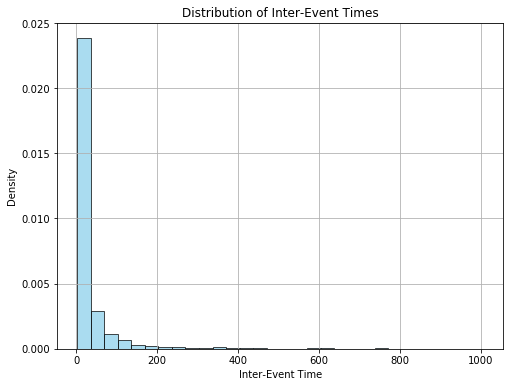

In [249]:
inter_event_times = calculate_inter_event_times(rainy_periods)
is_exponential_distribution2(inter_event_times, 0.05)
plot_inter_event_times(inter_event_times)

### Test different tbo values and check whether they resul in exponentially distributed inter-event times

In [163]:
threshold_values = range(0,10)
cv_values = simulate_cv_threshold(inter_event_times, threshold_values)

# # Find the index of the minimum CV value
optimal_threshold_index = np.argmin(cv_values)
optimal_threshold = threshold_values[optimal_threshold_index]
optimal_cv = cv_values[optimal_threshold_index]

print("Optimal Threshold Value:", optimal_threshold)
print("Optimal Coefficient of Variation (CV):", optimal_cv)

Optimal Threshold Value: 9
Optimal Coefficient of Variation (CV): 1.3511291665757628


False


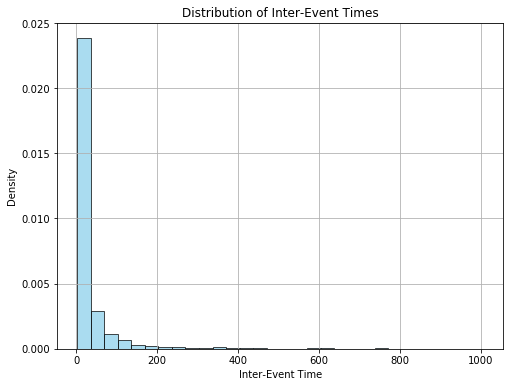

False


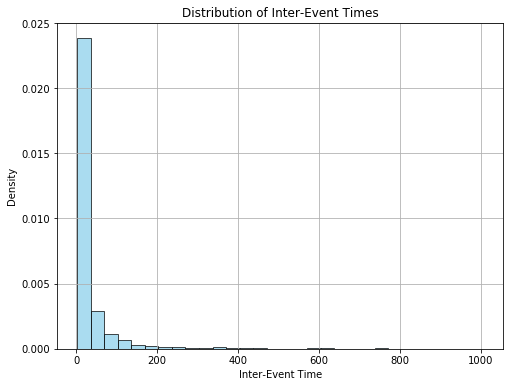

False


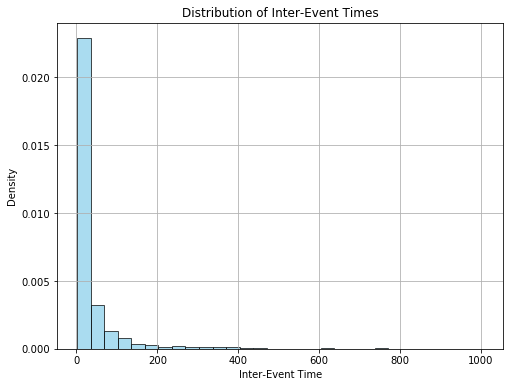

False


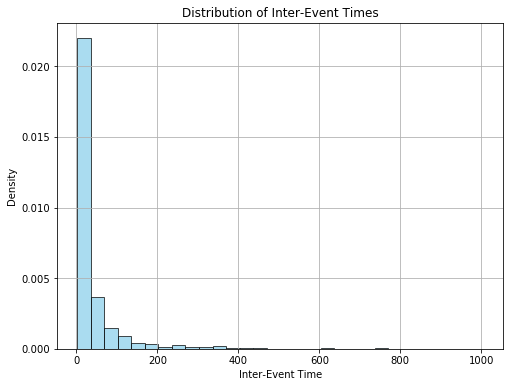

False


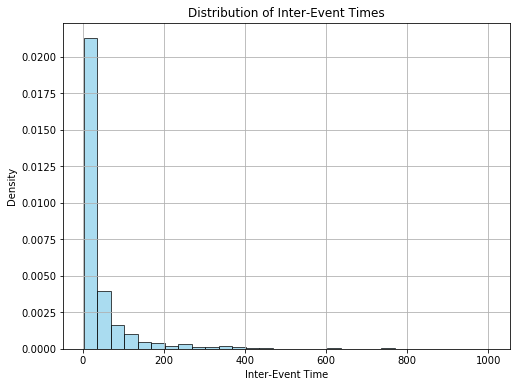

False


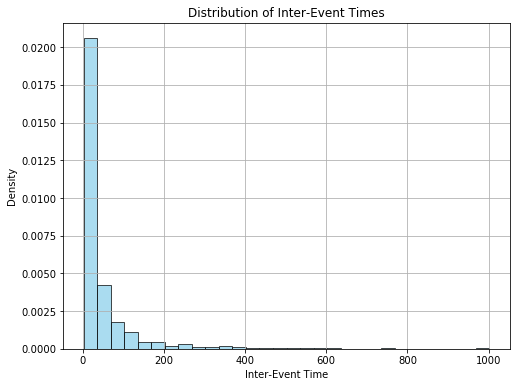

False


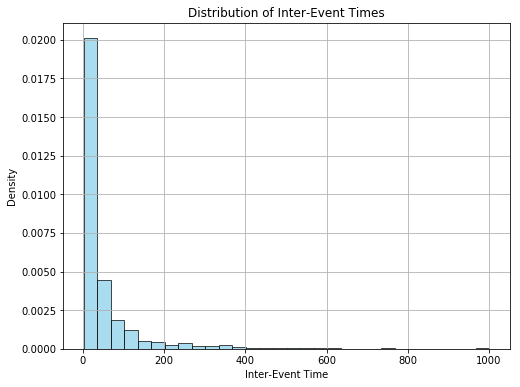

False


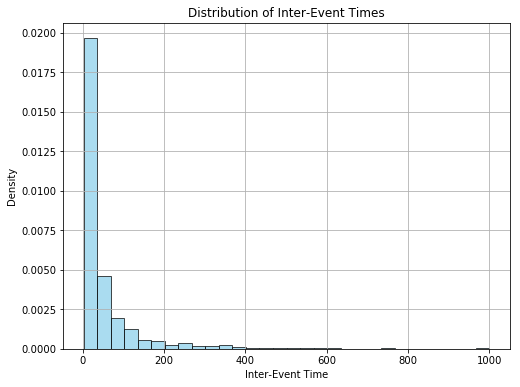

False


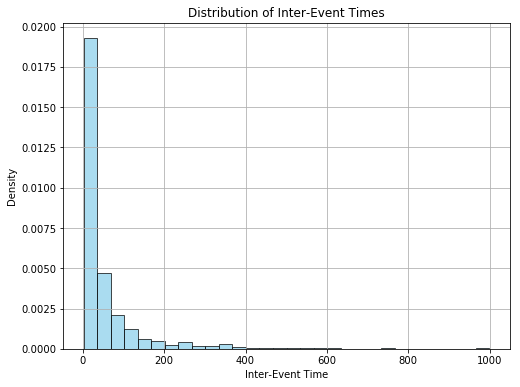

False


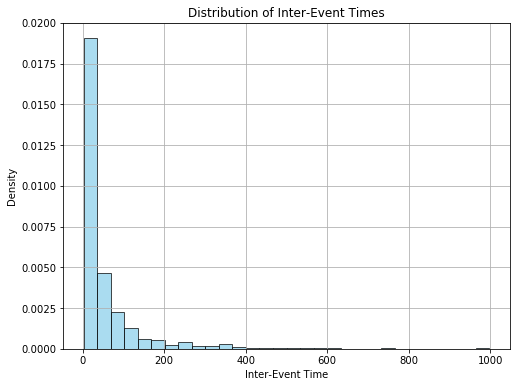

In [153]:
for dry_spell_threshold in range(0,10):
    rainy_periods = identify_rainy_periods(rainfall_data,is_raining_threshold = 0.1, dry_spell_threshold = dry_spell_threshold)
    inter_event_times = calculate_inter_event_times(rainy_periods)
    # is_exponential_distribution1(inter_event_times, 0.05)
    is_exponential_distribution2(inter_event_times, 1)
    plot_inter_event_times(inter_event_times)

In [83]:
data = inter_event_times
alpha=0.05

scale = 1 / np.mean(data)
print(scale)
print(np.mean(data))
exponential_dist = expon(scale=scale)

# Perform the Kolmogorov-Smirnov test
_, p_value = kstest(data, exponential_dist.cdf)

# Compare the p-value to the significance level alpha
print( p_value > alpha)

0.023868373482864205
41.89644513137558
False


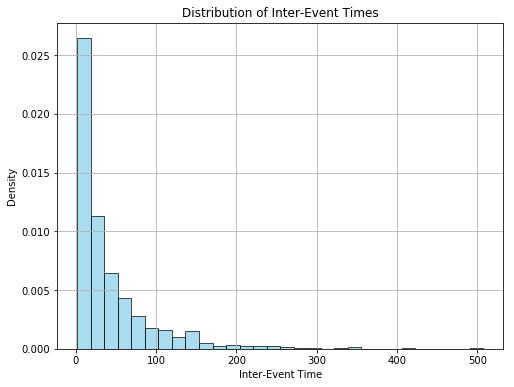

In [76]:
plot_inter_event_times(inter_event_times)

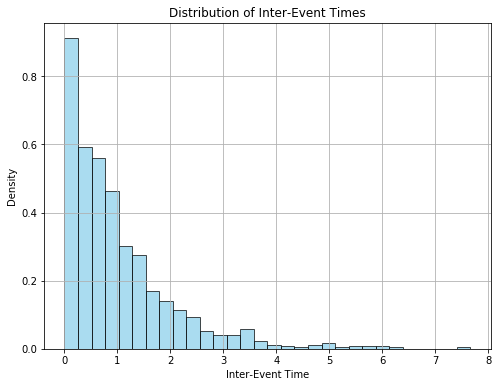

In [51]:
plot_inter_event_times(exponential_data)

### Some test data which is exponentially distributed

In [242]:
scale = 1.0  # Scale parameter (inverse of lambda)

# Generate exponentially distributed data
data_size = 1000  # Number of data points
exponential_data = np.random.exponential(scale, size=data_size)

# Print the first 10 elements of the generated data
# print(exponential_data)[:10])

# Set the parameters for the normal distribution
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate normally distributed data
data_size = 1000  # Number of data points
normal_data = np.random.normal(mean, std_dev, size=data_size)

# Set the parameters for the Weibull distribution
shape = 1.5  # Shape parameter (affects skewness)
scale = 1.0  # Scale parameter (affects spread)

# Generate Weibull distributed data
data_size = 1000  # Number of data points
weibull_data = np.random.weibull(shape, size=data_size) * scale

import numpy as np

# Set the parameters for the exponential distribution
scale = 1.0  # Scale parameter (inverse of lambda)

# Generate exponentially distributed data
data_size = 10000  # Number of data points
exponential_data = np.random.exponential(scale, size=data_size)

# Add some normally distributed noise
noise_mean = 0
noise_std_dev = 0.2
noise = np.random.normal(noise_mean, noise_std_dev, size=data_size)

# Add noise to the exponential data
data_with_noise = exponential_data + noise


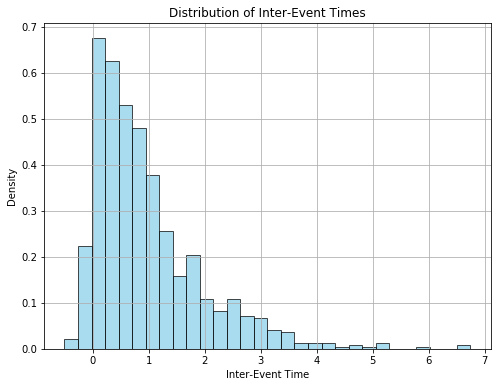

In [18]:
plot_inter_event_times(data_with_noise)

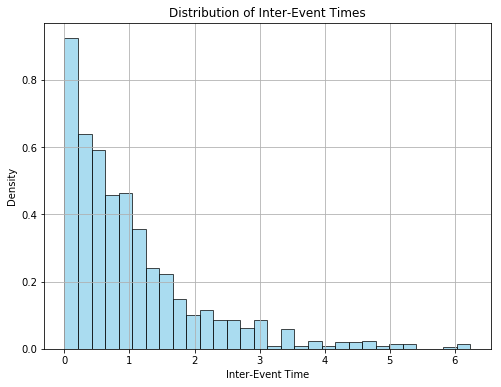

In [134]:
plot_inter_event_times(exponential_data)

In [ ]:
scale = 1 / np.mean(data)
exponential_dist = expon(scale=scale)

# Perform the Kolmogorov-Smirnov test
_, p_value = kstest(data, exponential_dist.cdf)

# Compare the p-value to the significance level alpha
print( p_value > alpha)

In [19]:
is_exponential_distribution1(inter_event_times, 0.05)
is_exponential_distribution2(inter_event_times, 0.05)

True
False


In [127]:
is_exponential_distribution1(weibull_data, 0.05)
is_exponential_distribution2(weibull_data, 0.05)

True
False


In [133]:
is_exponential_distribution1(exponential_data, 0.05)
is_exponential_distribution2(exponential_data, 0.05)

True
True


In [97]:
is_exponential_distribution1(exponential_data, 0.05)
is_exponential_distribution2(exponential_data, 0.05)

True
True


### New CV method

In [165]:
# Calculate the mean (first moment)
mean = np.mean(inter_event_times)

# Calculate the variance (second moment)
variance = np.var(inter_event_times)

print("Mean (First Moment):", mean)
print("Variance (Second Moment):", variance)

Mean (First Moment): 60.81581798483207
Variance (Second Moment): 9157.20334675777


In [175]:
N1 = len(inter_event_times) - hist[0]

hist[0]

41

In [234]:
def calculate_cv(inter_event_times, tb0):
    # Calculate the histogram with a bin width of 1
    hist, _ = np.histogram(inter_event_times, bins=np.arange(min(inter_event_times), max(inter_event_times) + 2))
    
    # Calculate N1
    # N1: The variable N1 represents the effective number of inter-event times considered in the calculation. 
    # It starts with the total number of inter-event times and decreases as the algorithm progresses through 
    # different values of tb0. Specifically, it represents the total number of inter-event times excluding the dry 
    # periods of length tb0.
    N1 = len(inter_event_times) - hist[0]
    
    # Calculate S1 and S2 for the initial tb0 (0)
    S1 = np.sum(np.cumsum(hist) * np.arange(len(hist)))
    S2 = np.sum(np.cumsum(hist) * np.arange(len(hist)) ** 2)
    
    # Calculate CV for tb0 = 0
    CV = np.sqrt((S2 - (S1 ** 2) / N1) / (N1 / (N1 - 1)) ) / (S1 / N1)
    
    # Iterate for other values of tb0
    for k in range(5, tb0):
        print(f"tbo is {k}")
        # Update N1
        N1 = N1 - hist[k]
        
        # Update S1 and S2
        S1 = (N1 - 1) * S1 / (N1 - hist[k])
        print(f"S1 is {S1}")
        
        S2 = (N1 - 1) * S2 / (N1 - hist[k]) - hist[k] * k ** 2
        print(f"S2 is {S2}")
        # Calculate CV for current tb0
        print((S2 - (S1 ** 2) / N1) / (N1 / (N1 - 1)))
        current_CV = np.sqrt((S2 - (S1 ** 2) / N1) / (N1 / (N1 - 1))) / (S1 / N1)
        
        # Check if CV has stabilized
        if np.isclose(CV, current_CV):
            return k
        
        CV = current_CV
    
    return tb0

# Example value for tb0
tb0 = 100

# Calculate the optimal value for tb0
optimal_tb0 = calculate_cv(inter_event_times, tb0)
print("Optimal tb0:", optimal_tb0)

tbo is 5
S1 is 1355371151.954852
S2 is 910464540375.1635
-902695745768134.9
tbo is 6
S1 is 1413354944.551851
S2 is 949414892127.6196
-1022397216459200.9
tbo is 7
S1 is 1458076486.71443
S2 is 979456386096.086
-1122098952053784.9
tbo is 8
S1 is 1504000155.5873253
S2 is 1010305402482.6084
-1231024992575733.8
tbo is 9
S1 is 1544648808.4410367
S2 is 1037610950013.0573
-1333380863577634.0
tbo is 10
S1 is 1581836477.9337451
S2 is 1062591596987.7697
-1432045589609412.2
tbo is 11
S1 is 1618888503.543004
S2 is 1087481125050.1859
-1535137708489499.0
tbo is 12
S1 is 1656699052.4886918
S2 is 1112880186890.7974
-1645348952566286.8
tbo is 13
S1 is 1698534887.147497
S2 is 1140983214984.2922
-1773164559214460.5
tbo is 14
S1 is 1736814810.553912
S2 is 1166697575297.5454
-1896019251412258.0
tbo is 15
S1 is 1763899641.907579
S2 is 1184891683907.205
-1986892974391908.0
tbo is 16
S1 is 1790660652.305913
S2 is 1202868266635.1482
-2079566387631929.5
tbo is 17
S1 is 1823240057.7050097
S2 is 1224753328084.3538


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


In [248]:
inter_event_times

array([3.07889091, 0.58849777, 1.07418427, ..., 0.23777945, 0.37312514,
       1.26588972])

In [187]:
tbo = 1
filtered_inter_event_times = [time for time in inter_event_times if time >= tbo]
len(filtered_inter_event_times)

923

## New method of finding inter-event times

In [217]:
def calculate_cv(inter_event_times):
    mean = np.mean(inter_event_times)
    variance = np.var(inter_event_times)
    std_dev = np.sqrt(variance)
    cv = std_dev / mean
    return cv

def iterate_over_tbo(inter_event_times, tbo_values):
    cv_values = []
    for tbo in tbo_values:
        # Filter inter-event times based on tbo
        filtered_inter_event_times = [time for time in inter_event_times if time >= tbo]
        cv = calculate_cv(filtered_inter_event_times)
        cv_values.append(cv)
    return cv_values

# Example usage
tbo_values = [1,2,3,4,5,6,7,8,9, 10, 11,12,13,14, 15,16,17,18,19, 20]  # Example tbo values
cv_values = iterate_over_tbo(inter_event_times, tbo_values)
print("Coefficient of Variation for different tbo values:", cv_values)

Coefficient of Variation for different tbo values: [2.2165870425519243, 2.2165870425519243, 2.010725270546958, 1.8633377856224445, 1.749506661474289, 1.6654139708331237, 1.6023595452051256, 1.5379481231353667, 1.4866581906549154, 1.4485338039575617, 1.4111302547429452, 1.3791496378526726, 1.3508393853796115, 1.323576265168709, 1.2966370068992545, 1.2677844072095832, 1.241913259558922, 1.2237295705912454, 1.2061898508601132, 1.1855166704781845]


In [252]:
import numpy as np

def calculate_cv(inter_event_times, tb0):
    # Calculate the histogram with a bin width of 1
    hist, _ = np.histogram(inter_event_times, bins=np.arange(min(inter_event_times), max(inter_event_times) + 2))
    
    # Calculate N1
    N1 = len(inter_event_times) - hist[0]
    
    # Calculate S1 and S2 for the initial tb0 (0)
    S1 = np.sum(np.cumsum(hist) * np.arange(len(hist)))
    S2 = np.sum(np.cumsum(hist) * np.arange(len(hist)) ** 2)
    
    # Calculate CV for tb0 = 0
    CV = np.sqrt((S2 - (S1 ** 2) / N1) / (N1 / (N1 - 1)) ) / (S1 / N1)
    
    # Iterate for other values of tb0
    for k in range(1, tb0):
        # Update N1
        N1 = N1 - hist[k]
        
        # Update S1 and S2
        S1 = (N1 - 1) * S1 / (N1 - hist[k])
        S2 = (N1 - 1) * S2 / (N1 - hist[k]) - hist[k] * k ** 2
        
        # Calculate CV for current tb0
        current_CV = np.sqrt((S2 - (S1 ** 2) / N1) / (N1 / (N1 - 1))) / (S1 / N1)
        
        
        if np.isclose(CV, current_CV):
            print("cv stablised")
        else:
            print("it isnt stabilising")
        
        # Check if CV has stabilized
        if np.isclose(CV, current_CV):
            return k
        
        CV = current_CV
    
    return tb0

# Example inter-event times
# Example value for tb0
tb0 = 10

# Calculate the optimal value for tb0
optimal_tb0 = calculate_cv(inter_event_times, tb0)
print("Optimal tb0:", optimal_tb0)


it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
it isnt stabilising
Optimal tb0: 10


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


In [259]:
# Calculate the histogram with a bin width of 1
hist, _ = np.histogram(inter_event_times, bins=np.arange(min(inter_event_times), max(inter_event_times) + 2))

# Calculate N1
N1 = len(inter_event_times) - hist[0]
hist[0]

425